# >Importing requisite packages:

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re 
import string 
import warnings 

### > Load datasets:

In [255]:
train_data = pd.read_csv("../input/sentiment-analysis-of-tweets/train.txt",  sep = ",")
test_data = pd.read_csv("../input/sentiment-analysis-of-tweets/test_samples.txt",  sep = ",")

Test and Train Datasets read


### > Exploratory Data Analysis:

In [256]:
print("Data Type : ", type(train_data))

Data Type :  <class 'pandas.core.frame.DataFrame'>


In [257]:
print("Top ten rows from start:\n")
train_data.head(10)

Top ten rows from start:



,tweet_id,sentiment,tweet_text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...
5,264229576773861376,neutral,I sat through this whole movie just for Harry ...
6,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,negative,Talking about ACT\u2019s && SAT\u2019s\u002c d...
8,212392538055778304,neutral,"Why is \""""Happy Valentines Day\"""" trending? It..."
9,254941790757601280,negative,They may have a SuperBowl in Dallas\u002c but ...


In [258]:
print("Rows:\n", train_data.index, "\n")
print("Columns:\n", train_data.columns, "\n")

Rows:
 RangeIndex(start=0, stop=21465, step=1) 

Columns:
 Index(['tweet_id', 'sentiment', 'tweet_text'], dtype='object') 



In [259]:
print("Features and their types:\n",train_data.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21465 entries, 0 to 21464
Data columns (total 3 columns):
tweet_id      21465 non-null int64
sentiment     21465 non-null object
tweet_text    21465 non-null object
dtypes: int64(1), object(2)
memory usage: 503.2+ KB
Features and their types:
 None 



#### As it comes out, No column has any missing value.

In [260]:
print ("Null Value Statistics:", '\n',train_data.isnull().sum()) #Tells the total no. of null values in the loaded dataset

Null Value Statistics: 
 tweet_id      0
sentiment     0
tweet_text    0
dtype: int64


In [261]:
print("Shape of Training Data:", train_data.shape, "\n")
###print("Rows in Train dataset = ", train_data.shape[0])
###print("Columns in Train dataset = ", train_data.shape[1])

Shape of Training Data: (21465, 3) 



In [262]:
print("See statistics for non-numerical columns : ")
train_data.describe(include=['object'])

See statistics for non-numerical columns : 


,sentiment,tweet_text
count,21465,21465
unique,3,21454
top,positive,Perseverance is failing 19 times and succeedin...
freq,9064,6


#### Sentiment column contains 3 labels.

In [263]:
print("Respective counts for categorical features in the sentiment column:")
train_data['sentiment'].value_counts()

Respective counts for categorical features in the sentiment column:


positive    9064
neutral     9014
negative    3387
Name: sentiment, dtype: int64

#### 3 labels are positive, neutral and negative

Respective percentages for the labels in the sentiment column:
positive    42.226881
neutral     41.993944
negative    15.779175
Name: sentiment, dtype: float64


<BarContainer object of 3 artists>

Text(0.5, 0, 'Sentiment Labels of tweets in train dataset')

Text(0, 0.5, '%')

Text(0.5, 1.0, '% of sentiment types of tweet')

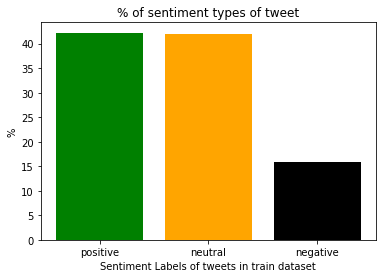

In [264]:
print("Respective percentages for the labels in the sentiment column:")
d = train_data['sentiment'].value_counts(normalize = True) * 100
print(d)
plt.bar(x = d.index, height = d.values, label = d.index, color= ['green','orange','black'])
plt.xlabel("Sentiment Labels of tweets in train dataset")
plt.ylabel("%")
plt.title("% of sentiment types of tweet")
plt.show()

#### As can be seen from above analysis: 
##### **Positive** tweets occupy **42.27%** of the total tweets.
##### **Neutral** tweets occupy **41.99%** of the total tweets.
##### **Negative** tweets occupy **15.78%** of the total tweets.

### Unnecessary 'tweet_id'  column is to be from the provided train dataset.

In [265]:
del train_data['tweet_id'] 
if (train_data.columns.tolist() == ['sentiment', 'tweet_text']):
  print("Col 'tweet_id' is removed from the train dataset.")
print(train_data)

Col 'tweet_id' is removed from the train dataset.
      sentiment                                         tweet_text
0      positive  Gas by my house hit $3.39!!!! I\u2019m going t...
1      negative  Theo Walcott is still shit\u002c watch Rafa an...
2      negative  its not that I\u2019m a GSP fan\u002c i just h...
3      negative  Iranian general says Israel\u2019s Iron Dome c...
4       neutral  Tehran\u002c Mon Amour: Obama Tried to Establi...
...         ...                                                ...
21460   neutral  the day after newark ill be able to say ""i me...
21461   neutral  FEC hold farewell session for seven ministers ...
21462   neutral  Luca Di Montezemolo (who's last day was Monday...
21463  positive  Coffee is pretty much the answer to all questi...
21464   neutral  Niki Lauda just confirmed to Sky that Alonso w...

[21465 rows x 2 columns]


### >Steps for carrying out Data Cleaning:
1.  Short Words lookup
2.  Emoticon(smiley) lookup 
3.  Lowercasing
4.  Apostrophe's contractions lookup
5.  Replacing unicode emojis with associated emotion.
6.  Removing rest unicoded emojis.
7.  Removing non-ASCII characters.
8.  Removing numbers.
9.  Removing "#". 
10.  Removing "@". 
11. Removing usernames.
12. Removing 'RT'. 
13. Replacing all URLs and Links with word 'URL'.
14. Removing punctuations symbols
15. Removing special characters
16. Removing unit length words

In [266]:
from string import punctuation
print("Data Cleaning follows: \n")

# emoticon lookup
def replace_smileys(t):
  '''
  Replaces happy smileys with "happy" and sad smileys with "sad".
  '''
  emoti_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':D',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'])

  emoti_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('])  

  words = t.split()
  reformed = []
  for w in words:
    if w in emoti_happy:
      reformed.append("happy")
    elif w in emoti_sad:
      reformed.append("sad") 
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t


# emojis lookup
emoji_pattern = re.compile("["
         u"\U0001F300-\U0001F5FF" 
         u"\U0001F680-\U0001F6FF"  
         u"\U0001F1E0-\U0001F1FF"  
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def replace_emojis(t):
  '''
  Replace happy emotion unicode emojis with "happy" & sad emotion unicode emojis with "sad".
  '''
  emoji_happy = ["\U0001F600", "\U0001F601", "\U0001F602","\U0001F603","\U0001F604","\U0001F605", "\U0001F606", "\U0001F607", "\U0001F609", 
                "\U0001F60A", "\U0001F642","\U0001F643","\U0001F923",r"\U0001F970","\U0001F60D", r"\U0001F929","\U0001F618","\U0001F617",
                r"\U000263A", "\U0001F61A", "\U0001F619", r"\U0001F972", "\U0001F60B", "\U0001F61B", "\U0001F61C", r"\U0001F92A",
                "\U0001F61D", "\U0001F911", "\U0001F917", r"\U0001F92D", r"\U0001F92B","\U0001F914","\U0001F910", r"\U0001F928", "\U0001F610", "\U0001F611",
                "\U0001F636", "\U0001F60F","\U0001F612", "\U0001F644","\U0001F62C","\U0001F925","\U0001F60C","\U0001F614","\U0001F62A",
                "\U0001F924","\U0001F634", "\U0001F920", r"\U0001F973", r"\U0001F978","\U0001F60E","\U0001F913", r"\U0001F9D0"]

  emoji_sad = ["\U0001F637","\U0001F912","\U0001F915","\U0001F922", r"\U0001F92E","\U0001F927", r"\U0001F975", r"\U0001F976", r"\U0001F974",
                       "\U0001F635", r"\U0001F92F", "\U0001F615","\U0001F61F","\U0001F641", r"\U0002639","\U0001F62E","\U0001F62F","\U0001F632",
                       "\U0001F633", r"\U0001F97A","\U0001F626","\U0001F627","\U0001F628","\U0001F630","\U0001F625","\U0001F622","\U0001F62D",
                       "\U0001F631","\U0001F616","\U0001F623"	,"\U0001F61E","\U0001F613","\U0001F629","\U0001F62B", r"\U0001F971",
                       "\U0001F624","\U0001F621","\U0001F620", r"\U0001F92C","\U0001F608","\U0001F47F","\U0001F480", r"\U0002620"]

  words = t.split()
  reformed = []
  for w in words:
    if w in emoji_happy:
      reformed.append("happy")
    elif w in emoji_sad:
      reformed.append("sad") 
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t

# short word lookup
def short_word_lookup(t):
  '''
  replaces common shorthands to full
  '''  
  short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}
  words = t.split()
  reformed = []
  for w in words:
    if w in short_word_dict:
      reformed.append(short_word_dict[w])
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t

def replace_contractions(t):
  '''
  Apostrophe's lookup
  '''
  cont = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
 }
  words = t.split()
  reformed = []
  for w in words:
    if w in cont:
      reformed.append(cont[w])
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t  

def remove_single_letter_words(t):
  '''
  Remove unit length words.
  '''
  words = t.split()
  reformed = []
  for w in words:
    if len(w) > 1:
      reformed.append(w)
  t = " ".join(reformed)
  return t  

def dataclean(t):
  '''
  This function cleans the tweets.
  '''
  t = short_word_lookup(t)
  t = replace_smileys(t) # replace handwritten emojis with their feeling associated
  t = t.lower() 
  t = replace_contractions(t) # replace short forms used in english  with their actual words
  t = replace_emojis(t) # replace unicode emojis with their feeling associated
  t = emoji_pattern.sub(r'', t) # remove emojis other than smiley emojis
  t = re.sub('\\\\u[0-9A-Fa-f]{4}','', t) # remove NON- ASCII characters
  t = re.sub("[0-9]", " ", t) # remove integers with space # re.sub("\d+", "", t)
  t = re.sub('#', '', t) # remove '#'
  t = re.sub('@[A-Za-z0–9]+', '', t) # remove '@'

  t = re.sub('@[^\s]+', '', t) # remove usernames
 
  t = re.sub('RT[\s]+', '', t) # remove retweet 'RT'
  t = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', t) # remove URL's
  t = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', ' ', t) # remove punctuations with space
  t = re.sub(r'[^a-zA-Z0-9]',' ', t) # remove speacial characters with space
  t = remove_single_letter_words(t) 
  return t

print("Cleaning the tweets from the data.\n")

train_data['tweet_text'] = train_data['tweet_text'].apply(dataclean)
print("Tweets are cleaned.")
print(train_data)

Data Cleaning follows: 

Cleaning the tweets from the data.

Tweets are cleaned.
      sentiment                                         tweet_text
0      positive  gas by my house hit im going to chapel hill on...
1      negative  theo walcott is still shit watch rafa and john...
2      negative  its not that im gsp fan just hate nick diaz ca...
3      negative  iranian general says israels iron dome cant de...
4       neutral  tehran mon amour obama tried to establish ties...
...         ...                                                ...
21460   neutral  the day after newark ill be able to say met de...
21461   neutral  fec hold farewell session for seven ministers ...
21462   neutral  luca di montezemolo who last day was monday on...
21463  positive  coffee is pretty much the answer to all questi...
21464   neutral  niki lauda just confirmed to sky that alonso w...

[21465 rows x 2 columns]


### >Data Preprocessing follows (Tokenization, Removing Stopwords, Lemmatization):

Preprocessing the tweets...
After preprocessing. ['gas house hit im go chapel hill sit happy', 'theo walcott still shit watch rafa johnny deal saturday', 'im gsp fan hate nick diaz cant wait february', 'iranian general say israels iron dome cant deal missiles keep talk like may end find', 'tehran mon amour obama try establish tie mullahs via com barack obama vote mitt romney']
Top 20 words used in the tweets are : 
 ['gas', 'house', 'hit', 'im', 'go', 'chapel', 'hill', 'sit', 'happy', 'theo', 'walcott', 'still', 'shit', 'watch', 'rafa', 'johnny', 'deal', 'saturday', 'im', 'gsp']

Frequency distribution of top 20 words in the tweets.

<FreqDist with 27843 samples and 248475 outcomes>
Top 20 most common words in the data. 

      Tokens  Frequency
0   tomorrow       3591
1         go       2891
2        may       2880
3         th       2780
4        get       2070
5        day       1790
6        see       1517
7      night       1485
8         st       1465
9       time       1331
10  

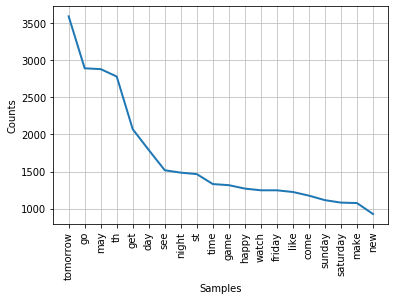

In [267]:
def freq_words(tokens):
  from nltk.probability import FreqDist
  
  fdist = FreqDist(tokens)
  print(fdist)

  print("Top 20 most common words in the data. \n")
  df = pd.DataFrame(fdist.most_common(20), columns=['Tokens', 'Frequency'])
  print(df)

  fdist.plot(20, cumulative = False)
  plt.show()

def preprocess(t):
  from nltk.tokenize import word_tokenize
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
   
  from nltk.stem.wordnet import WordNetLemmatizer
  lem = WordNetLemmatizer()
  
  # tokenization
  tw = []  
  tw = word_tokenize(t)  
  
  # remove the stopwords
  fs = [] 
  fs = ([i for i in tw if i not in stop_words])
  
  # lemmatization  
  ns = []
  for i in fs:
    ns.append(lem.lemmatize(i, 'v'))
  ns = ' '.join(ns)
  return ns  

print("Preprocessing the tweets...")
  
pp_list = []
for tweet in train_data['tweet_text']:
  pp_list.append(preprocess(tweet))
print("After preprocessing.", pp_list[:5])

from nltk.tokenize import word_tokenize
tokens = []
for i in pp_list:
  tokens.extend(word_tokenize(i))
print("Top 20 words used in the tweets are : \n", tokens[:20])
print("\nFrequency distribution of top 20 words in the tweets.\n")
freq_words(tokens)

### >Split - 80% and 20% of the train data into training and validation:

In [268]:
from sklearn.model_selection import train_test_split  
x = pp_list
y = train_data['sentiment'].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 1)
print("Data points in training data :\n")
print("x1 = ", len(x_train))
print("y1 = ", len(y_train))

print("\nData points in validation data :\n")
print("x2 = ", len(x_val))
print("y2 = ", len(y_val))

Data points in training data :

x1 =  17172
y1 =  17172

Data points in validation data :

x2 =  4293
y2 =  4293


### >Generating the Feature:

In [269]:
print("Using TF-IDF approach \n")

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)

val_vectors = vectorizer.transform(x_val)
print("Shape of training data : ",train_vectors.shape, "\nShape of validation data : ",val_vectors.shape)

Using TF-IDF approach 

Shape of training data :  (17172, 24218) 
Shape of validation data :  (4293, 24218)


### >Building the SVM model ie Support Vector Machine:

In [270]:
from sklearn import svm
model_SVM = svm.SVC(kernel='linear')
model_SVM.fit(train_vectors, y_train)
print("\nSVM model is now trained.")

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


SVM model is now trained.


### >Testing the Model on the Validation Dataset:

Testing our Model's performance...

Analysis after prediction : 

neutral     51.15304
positive    40.11181
negative     8.73515
Name: predicted, dtype: float64


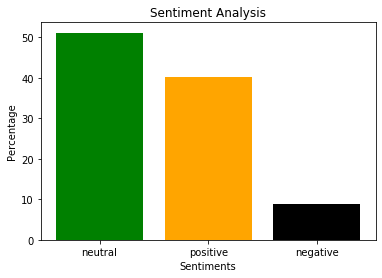

Confusion Matrix :
 [[ 229  328  104]
 [ 109 1322  399]
 [  37  546 1219]]
classification report: 
               precision    recall  f1-score   support

    negative       0.61      0.35      0.44       661
     neutral       0.60      0.72      0.66      1830
    positive       0.71      0.68      0.69      1802

    accuracy                           0.65      4293
   macro avg       0.64      0.58      0.60      4293
weighted avg       0.65      0.65      0.64      4293

Accuracy score  =  64.52364313999534


In [271]:
def performance(model, y_true, vectors):
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
  y_pred = model.predict(vectors)   
  df = pd.DataFrame({'actual' : y_true, 'predicted' : y_pred})
  print("\nAnalysis after prediction : \n")
  d = df['predicted'].value_counts(normalize = True) * 100 
  print(d)
  
  plt.bar(x = d.index, height = d.values, label = d.index, color= ['green','orange','black'])
  plt.xlabel("Sentiments")
  plt.ylabel("Percentage")
  plt.title('Sentiment Analysis')
  plt.show()
  
  cm = confusion_matrix(y_true,y_pred)
  crp = classification_report(y_true,y_pred)
  acc = accuracy_score(y_true,y_pred)
  return (cm, crp, acc)

print("Testing our Model's performance...")
perform = performance(model_SVM, y_val, val_vectors)
print("Confusion Matrix :\n", perform[0])  
print("classification report: \n", perform[1])  
print("Accuracy score  = ", perform[2] *100)

### SVM Model gives an accuracy of 64.52%

### >Testing model on test dataset:

In [272]:
test_data.head()
test_data['tweet_text'] = test_data['tweet_text'].apply(dataclean)

print("Building Features for the test data set:\n")
test_list = []
for tweet in test_data['tweet_text']:
  test_list.append(preprocess(tweet))
print("After preprocessing: \n", test_list[:5], "\n")

test_vectors = vectorizer.transform(test_list)
print("Shape of testing features : ",test_vectors.shape)

print("\nTesting the performance.....\n")
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
predicted = model_SVM.predict(test_vectors)

print("Results:")
results = pd.DataFrame({'tweet_id' : test_data['tweet_id'].astype(str), 'sentiment' : predicted}, 
                       columns = ['tweet_id', 'sentiment'])
print(results)
results.to_csv("results_SVM.csv", sep= ",", index = False)

print("Analysis on the test dataset..")
d = results['sentiment'].value_counts(normalize = True) * 100
if (d.index[np.argmax(d.values)] == 'positive'): 
  print("\nMajority Positive Sentiment.")
  print("Percentage = ", d.values[np.argmax(d.values)])
elif (d.index[np.argmax(d.values)] == 'negative'): 
  print("\nMajority Negative Sentiment.")
  print("Percentage = ", d.values[np.argmax(d.values)])
else:
  print("\nMajority Neutral Sentiment.")
  print("Percentage = ", d.values[np.argmax(d.values)])  

,tweet_id,tweet_text
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor..."
1,218775148495515649,Musical awareness: Great Big Beautiful Tomorro...
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susa..."
4,171874368908050432,"Excuse the connectivity of this live stream, f..."


Building Features for the test data set:

After preprocessing: 
 ['atlantic city ventnor margate ocean city area wait coordinator hopefully call tomorrow', 'musical awareness great big beautiful tomorrow end time', 'radio fm fri oct labour analyst shawn hattingh cosatu role context unrest mine pjzzl', 'kapan sih lo ngebuktiin jan ngomong doang susah susah usaha aja blm udh nyerah inget never try shall never know cowok kok gentle bgt', 'excuse connectivity live stream baba amr many activists use one sit modem live ihz homs'] 

Shape of testing features :  (5398, 24218)

Testing the performance.....

Results:
                tweet_id sentiment
0     264238274963451904  positive
1     218775148495515649  positive
2     258965201766998017   neutral
3     262926411352903682   neutral
4     171874368908050432   neutral
...                  ...       ...
5393  210378118865756160   neutral
5394  245177521304399872  positive
5395  259280987089932288   neutral
5396  201113950211940352   neutral


### SVM Model predicts major sentiments as Neutral, 54.94%